In [2]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # self.fc1 = nn.Linear(64*64, 192)
        self.conv1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        self.fc2 = nn.Linear(18*64*64, 192)
        self.fc3 = nn.Linear(192, 192)
        self.fc4 = nn.Linear(192, 192)
        self.fc5 = nn.Linear(192, 192)
        self.fc6 = nn.Linear(192, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 18*64*64)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        
        return F.softmax(x, dim=1)

In [4]:
X = np.load("datasets/sign-language/X.npy")
Y = np.load("datasets/sign-language/Y.npy")

In [5]:
import random
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
indices = list(range(2062))
random.shuffle(indices)
train_indices = indices[:int(0.8 * 2062)]
test_indices = indices[int(0.8 * 2062):]

X_train = [X[i] for i in train_indices]
Y_train = [int(torch.argmax(torch.tensor(Y[i]))) for i in train_indices]
X_test = [X[i] for i in test_indices]
Y_test = [int(torch.argmax(torch.tensor(Y[i]))) for i in test_indices]

In [6]:
X_train = torch.tensor(X_train).float().to(device)
Y_train = torch.tensor(Y_train).to(device)
X_test = torch.tensor(X_test).float().to(device)
Y_test = torch.tensor(Y_test).to(device)

In [45]:
net = Net().cuda()

In [46]:
output = net(X_train[0].view(1, 1, 64, 64))
output

tensor([[0.1005, 0.0923, 0.1035, 0.1048, 0.1039, 0.1018, 0.1034, 0.1022, 0.0958,
         0.0918]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [47]:
import torch.optim as optim
optimizer = optim.Adam([net.conv1.weight, net.fc2.weight, net.fc3.weight, net.fc4.weight, net.fc5.weight, net.fc6.weight], lr=0.001)
X_train = X_train
Y_train = Y_train

error_in = []
error_out_approx = []
for i in range(500):
    net.zero_grad()
    output = net(X_train.view(len(train_indices), 1, 64, 64))
    loss = F.cross_entropy(output, Y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    error_in.append(float(loss))
    output_test = net(X_test.view(len(test_indices), 1, 64, 64))
    loss_test = F.cross_entropy(output_test, Y_test)
    error_out_approx.append(float(loss_test))

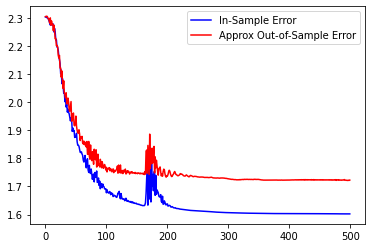

In [48]:
fig, ax = plt.subplots()
ax.plot(error_in, "b-", label="In-Sample Error")
ax.plot(error_out_approx, "r-", label="Approx Out-of-Sample Error")
leg = ax.legend()

In [49]:
output_test = net(X_test.view(len(test_indices), 1, 64, 64))

In [50]:
total = 0
correct = 0
for i, out_t in enumerate(output_test):
    if int(torch.argmax(out_t)) - int(Y_test[i]) == 0:
        correct = correct + 1
    total = total + 1

print(correct/total)

0.7336561743341404


In [51]:
class NetTwo(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool = nn.MaxPool2d(2, stride=2)
        self.dense = nn.Linear(32*32, 128)
        self.dense_output = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = x.view(-1, 1*32*32)
        x = F.relu(self.dense(x))
        x = self.dense_output(x)
        
        return F.softmax(x, dim=1)

In [52]:
net_two = NetTwo().cuda()

In [53]:
output_two = net_two(X_train[0].view(1, 1, 64, 64))
output_two

tensor([[0.0977, 0.0938, 0.1000, 0.0994, 0.1073, 0.1129, 0.0894, 0.0913, 0.0989,
         0.1095]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [54]:
import torch.optim as optim
optimizer = optim.Adam([net_two.conv1.weight, net_two.dense.weight, net_two.dense_output.weight], lr=0.001)
X_train = X_train
Y_train = Y_train

error_in_two = []
error_out_approx_two = []
for i in range(500):
    net.zero_grad()
    output = net_two(X_train.view(len(train_indices), 1, 64, 64))
    loss = F.cross_entropy(output, Y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    error_in_two.append(float(loss))
    output_test = net_two(X_test.view(len(test_indices), 1, 64, 64))
    loss_test = F.cross_entropy(output_test, Y_test)
    error_out_approx_two.append(float(loss_test))

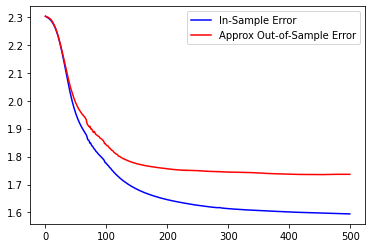

In [55]:
fig, ax = plt.subplots()
ax.plot(error_in_two, "b-", label="In-Sample Error")
ax.plot(error_out_approx_two, "r-", label="Approx Out-of-Sample Error")
leg = ax.legend()

In [56]:
output_test_two = net_two(X_test.view(len(test_indices), 1, 64, 64))

In [58]:
total = 0
correct = 0
for i, out_t in enumerate(output_test_two):
    if int(torch.argmax(out_t)) - int(Y_test[i]) == 0:
        correct = correct + 1
    total = total + 1

print(correct/total)

0.7263922518159807


In [68]:
class NetThree(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool2 = nn.MaxPool2d(2, stride=2)
        self.dense = nn.Linear(16*16, 128)
        self.dense_output = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = x.view(-1, 1*16*16)
        x = F.relu(self.dense(x))
        x = self.dense_output(x)
        
        return F.softmax(x, dim=1)

In [69]:
net_three = NetThree().cuda()

In [70]:
output_three = net_three(X_train[0].view(1, 1, 64, 64))
output_three

tensor([[0.1022, 0.1042, 0.0907, 0.1056, 0.1018, 0.0960, 0.0985, 0.0955, 0.0949,
         0.1106]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [71]:
import torch.optim as optim
optimizer = optim.Adam([net_three.conv1.weight, net_three.conv2.weight, net_three.dense.weight, net_three.dense_output.weight], lr=0.001)
X_train = X_train
Y_train = Y_train

error_in_three = []
error_out_approx_three = []
for i in range(500):
    net_three.zero_grad()
    output = net_three(X_train.view(len(train_indices), 1, 64, 64))
    loss = F.cross_entropy(output, Y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    error_in_three.append(float(loss))
    output_test = net_three(X_test.view(len(test_indices), 1, 64, 64))
    loss_test = F.cross_entropy(output_test, Y_test)
    error_out_approx_three.append(float(loss_test))

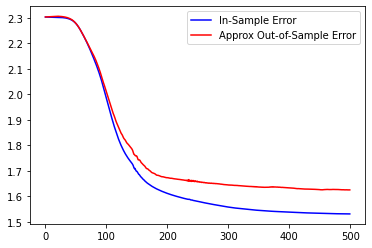

In [72]:
fig, ax = plt.subplots()
ax.plot(error_in_three, "b-", label="In-Sample Error")
ax.plot(error_out_approx_three, "r-", label="Approx Out-of-Sample Error")
leg = ax.legend()

In [73]:
output_test_three = net_three(X_test.view(len(test_indices), 1, 64, 64))

In [74]:
total = 0
correct = 0
for i, out_t in enumerate(output_test_three):
    if int(torch.argmax(out_t)) - int(Y_test[i]) == 0:
        correct = correct + 1
    total = total + 1

print(correct/total)

0.8401937046004843


In [75]:
class NetFour(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.max_pool3 = nn.MaxPool2d(2, stride=2)
        self.dense = nn.Linear(8*8, 128)
        self.dense_output = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = x.view(-1, 1*8*8)
        x = F.relu(self.dense(x))
        x = self.dense_output(x)
        
        return F.softmax(x, dim=1)

In [84]:
net_four = NetFour().cuda()

In [85]:
output_four = net_four(X_train[0].view(1, 1, 64, 64))
output_four

tensor([[0.0942, 0.0957, 0.1027, 0.0957, 0.1082, 0.1075, 0.0977, 0.1026, 0.1011,
         0.0946]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [86]:
import torch.optim as optim
optimizer = optim.Adam([net_four.conv1.weight, net_four.conv2.weight, net_four.conv3.weight, net_four.dense.weight, net_four.dense_output.weight], lr=0.001)
X_train = X_train
Y_train = Y_train

error_in_four = []
error_out_approx_four = []
for i in range(500):
    net_four.zero_grad()
    output = net_four(X_train.view(len(train_indices), 1, 64, 64))
    loss = F.cross_entropy(output, Y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    error_in_four.append(float(loss))
    output_test = net_four(X_test.view(len(test_indices), 1, 64, 64))
    loss_test = F.cross_entropy(output_test, Y_test)
    error_out_approx_four.append(float(loss_test))

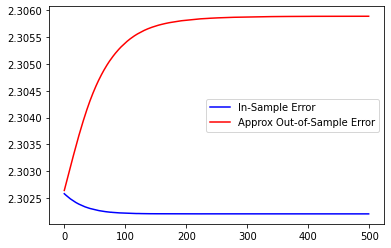

In [87]:
fig, ax = plt.subplots()
ax.plot(error_in_four, "b-", label="In-Sample Error")
ax.plot(error_out_approx_four, "r-", label="Approx Out-of-Sample Error")
leg = ax.legend()

In [82]:
output_test_four = net_four(X_test.view(len(test_indices), 1, 64, 64))

In [83]:
total = 0
correct = 0
for i, out_t in enumerate(output_test_four):
    if int(torch.argmax(out_t)) - int(Y_test[i]) == 0:
        correct = correct + 1
    total = total + 1

print(correct/total)

0.07990314769975787
